Successfully loaded 49240 training points from RuggedMueller_TrainingData_Correct.npz.


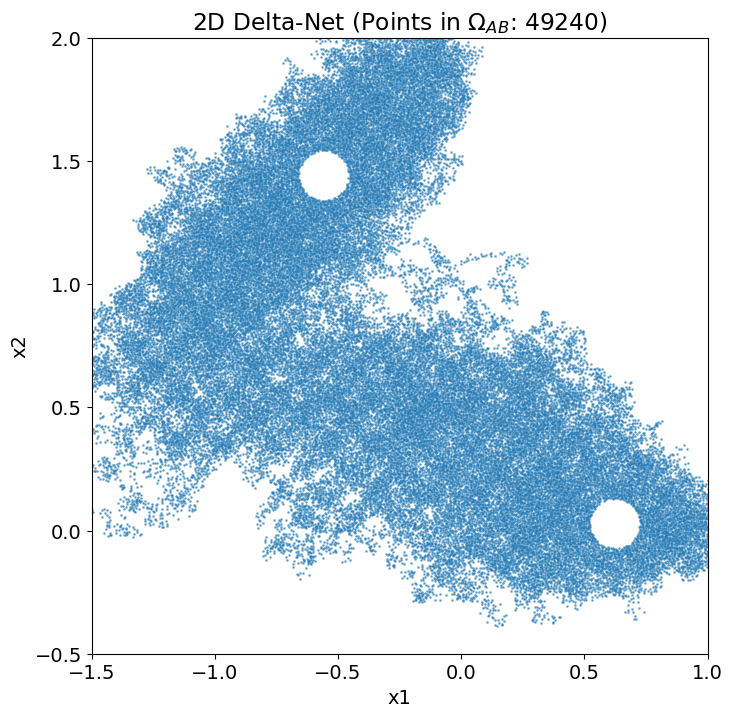

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ==============================================================================
# VISUALIZE THE 2D PROJECTION OF THE TRAINING DATA
# ==============================================================================

# --- Load the saved data ---
fname = "RuggedMueller_TrainingData_WORKED.npz"
data_loaded = False
try:
    data = np.load(fname)
    # Load the transition points (the actual training set)
    xy_omegaAB = data['trans_pts']
    data_loaded = True
    print(f"Successfully loaded {xy_omegaAB.shape[0]} training points from {fname}.")
except FileNotFoundError:
    print(f"ERROR: Data file not found: {fname}")
except Exception as e:
    print(f"An error occurred: {e}")

# --- Plot the 2D projection ---
if data_loaded:
    plt.figure(figsize=(8, 8)) # Use a square figure for equal aspect
    plt.rcParams.update({'font.size': 14}) # Set font size

    # Create a scatter plot using only the x1 (column 0) and x2 (column 1)
    plt.scatter(xy_omegaAB[:, 0], xy_omegaAB[:, 1], s=1, alpha=0.5)

    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(f"2D Delta-Net (Points in $\Omega_{{AB}}$: {xy_omegaAB.shape[0]})")
    
    # Set plot limits and aspect ratio to match your example
    plt.xlim(-1.5, 1.0)
    plt.ylim(-0.5, 2.0)
    axes = plt.gca()
    axes.set_aspect('equal')

    plt.show()

--- Step 1: Defining Parameters and Potential Functions ---
--- Step 2: Defining the 10D Neural Network Model ---
CommittorModelNN(
  (linear0): Linear(in_features=10, out_features=10, bias=True)
  (activation0): Tanh()
  (linear1): Linear(in_features=10, out_features=10, bias=True)
  (activation1): Tanh()
  (linear2): Linear(in_features=10, out_features=10, bias=True)
  (activation2): Tanh()
  (linear3): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

--- Step 3: Loading 10D Training Data ---
Loaded 49240 training points from RuggedMueller_TrainingData_Correct.npz.
Finding V_min for loss function stability...
Global V_min (on training set): -146.9389

--- Step 4: Training the 10D Model ---
--- Starting Training (10D Model, Paper Specs, Stable Loss, Explicit Grad) ---
Epoch 0/400, Avg. Loss: 1.8648e+01
Epoch 200/400, Avg. Loss: 2.8321e-03
Epoch 399/400, Avg. Loss: 2.4619e-03
--- Training Finished in 402.20 seconds ---

--- Step 5: Visualizing the Final Commi

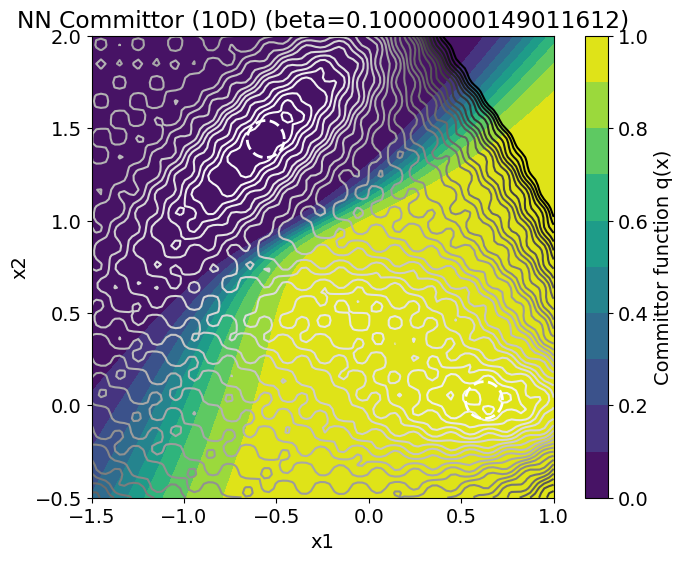

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import time
import os

# Set default tensor type
torch.set_default_dtype(torch.float32)

# ==============================================================================
# STEP 1: DEFINE PARAMETERS AND POTENTIAL FUNCTIONS
# (This is needed for the model and data loading)
# ==============================================================================
print("--- Step 1: Defining Parameters and Potential Functions ---")

# --- Problem Parameters ---
beta = torch.tensor(0.1) 
D_params_torch = torch.tensor([-200., -100., -170., 15.])
a_params_torch = torch.tensor([-1., -1., -6.5, 0.7])
b_params_torch = torch.tensor([0., 0., 11., 0.6])
c_params_torch = torch.tensor([-10., -10., -6.5, 0.7])
X_params_torch = torch.tensor([1., 0., -0.5, -1.])
Y_params_torch = torch.tensor([0., 0.5, 1.5, 1.])

gamma, k, sigma = 9.0, 5.0, 0.05
pi = torch.tensor(np.pi)

# Define 2D plot/sampling range
xmin, xmax = -1.5, 1.0
ymin, ymax = -0.5, 2.0

def Vpot_torch_2D_rugged(xy):
    """
    Calculates the 2D part of the rugged Mueller potential V_2D(x1, x2).
    Used for the re-weighted loss function.
    """
    x1 = xy[:, 0]
    x2 = xy[:, 1]
    V0 = 0.0
    for i in range(4):
        dx1 = x1 - X_params_torch[i]
        dx2 = x2 - Y_params_torch[i]
        V0 += D_params_torch[i] * torch.exp(a_params_torch[i] * dx1**2 + b_params_torch[i] * dx1 * dx2 + c_params_torch[i] * dx2**2)
    V_perturb = gamma * torch.sin(2 * k * pi * x1) * torch.sin(2 * k * pi * x2)
    return V0 + V_perturb

def Vpot_numpy_2D_rugged(xy):
    """
    Calculates the 2D rugged Mueller potential V(x1, x2, 0, ..., 0).
    Used for plotting the energy landscape.
    """
    x1 = xy[:, 0]
    x2 = xy[:, 1]
    V0 = 0.0
    for i in range(4):
        dx1 = x1 - X_params_torch.numpy()[i]
        dx2 = x2 - Y_params_torch.numpy()[i]
        V0 += D_params_torch.numpy()[i] * np.exp(a_params_torch.numpy()[i] * dx1**2 + b_params_torch.numpy()[i] * dx1 * dx2 + c_params_torch.numpy()[i] * dx2**2)
    V_perturb = gamma * np.sin(2 * k * pi.numpy() * x1) * np.sin(2 * k * pi.numpy() * x2)
    return V0 + V_perturb

# ==============================================================================
# STEP 2: DEFINE THE 10D NEURAL NETWORK MODEL (PER PAPER)
# ==============================================================================
print("--- Step 2: Defining the 10D Neural Network Model ---")

class CommittorModelNN(torch.nn.Module):
    """
    Neural Network model based on paper.
    L=3 hidden layers, W=10 neurons, 10D input.
    """
    def __init__(self, in_size, hidden_size, out_size):
        super(CommittorModelNN, self).__init__()
        
        # 3 hidden layers, 10 neurons
        self.linear0 = torch.nn.Linear(in_size, hidden_size)
        self.activation0 = torch.nn.Tanh()
        self.linear1 = torch.nn.Linear(hidden_size, hidden_size)
        self.activation1 = torch.nn.Tanh()
        self.linear2 = torch.nn.Linear(hidden_size, hidden_size)
        self.activation2 = torch.nn.Tanh()
        self.linear3 = torch.nn.Linear(hidden_size, out_size)
        self.sigmoid = torch.nn.Sigmoid()
                                      
    def forward(self, x, a, b, ra, rb, ea, eb, fac):
        q = self.linear0(x)
        q = self.activation0(q)
        q = self.linear1(q)
        q = self.activation1(q)
        q = self.linear2(q)
        q = self.activation2(q)
        q = self.linear3(q)
        q = self.sigmoid(q) 
        
        sizex, nothing = x.shape
        
        # Indicator functions depend only on (x1, x2)
        aux0 = (((x[:, 0:2] - a[0:2]).pow(2)).sum(dim=1)).reshape(sizex, 1) - (ra + ea.clone().detach()).pow(2)
        aux1 = (((x[:, 0:2] - b[0:2]).pow(2)).sum(dim=1)).reshape(sizex, 1) - (rb + eb.clone().detach()).pow(2)
        
        chia = 0.5 - 0.5 * torch.tanh(fac * aux0)
        chib = 0.5 - 0.5 * torch.tanh(fac * aux1)   
        
        q = (1 - chia) * ((1 - chib) * q + chib)
        return q

# --- Define sets A and B ---
minimum_a_2d = np.array([-0.558, 1.441])
minimum_b_2d = np.array([0.623, 0.028])
minimum_a = np.pad(minimum_a_2d, (0, 8), 'constant')
minimum_b = np.pad(minimum_b_2d, (0, 8), 'constant')
a = torch.from_numpy(minimum_a).float()
b = torch.from_numpy(minimum_b).float()

ra = torch.tensor(0.1)
rb = torch.tensor(0.1)
fac = torch.tensor(100.)
ea = 2. / (ra * fac)
eb = 2. / (rb * fac)

# --- Define the dimensions for the neural network (PER PAPER) ---
in_size = 10      # 10D input
hidden_size = 10  # 10 Neurons per layer
out_size = 1      # Output size

# Instantiate the model
qmodel = CommittorModelNN(in_size, hidden_size, out_size)
print(qmodel)

# ==============================================================================
# STEP 3: LOAD 10D TRAINING DATA
# ==============================================================================
print("\n--- Step 3: Loading 10D Training Data ---")

fname = "RuggedMueller_TrainingData_Correct.npz"
train_data = None
V_min_global = None

try:
    data = np.load(fname)
    # Load the transition points
    xy_omegaAB = data['trans_pts'].astype(np.float32)
    
    train_data = torch.from_numpy(xy_omegaAB)
    train_data.requires_grad_(True)
    
    size1, size2 = train_data.shape
    print(f"Loaded {size1} training points from {fname}.")

    # --- Find V_min for numerical stability ---
    print("Finding V_min for loss function stability...")
    # We only need the 2D coordinates for the V_2D part of the potential
    V_2D_all_pts = Vpot_torch_2D_rugged(train_data[:, 0:2])
    V_min_global = torch.min(V_2D_all_pts)
    print(f"Global V_min (on training set): {V_min_global.item():.4f}")

except FileNotFoundError:
    print(f"ERROR: Training data file not found: {fname}")
    print("Please run the data generation script first.")
except Exception as e:
    print(f"An error occurred: {e}")


# ==============================================================================
# STEP 4: TRAIN THE 10D MODEL
# ==============================================================================
print("\n--- Step 4: Training the 10D Model ---")

if train_data is not None:
    # To train the data in batch, use 'TensorDataset' and 'DataLoader'
    rhs = torch.zeros(size1,)
    train_dataset = TensorDataset(train_data, rhs)
    
    batch_size = 256 
    train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
    
    # Optimizer with low learning rate
    optimizer1 = optim.Adam(qmodel.parameters(), lr=1e-4)
    # Scheduler: reduce LR at 3000 and 4500 epochs
    scheduler1 = optim.lr_scheduler.MultiStepLR(optimizer1, milestones=[3000, 4500], gamma=0.1)
    Nepochs = 400
    
    print("--- Starting Training (10D Model, Paper Specs, Stable Loss, Explicit Grad) ---")
    start_time = time.time()

    for epoch in range(Nepochs):
        epoch_loss = 0.0
        num_batches = 0
        for X, y in train_dataloader:
            optimizer1.zero_grad()

            # Forward pass: q(x)
            q = qmodel(X, a, b, ra, rb, ea, eb, fac)

            # --- NUMERICALLY STABLE LOSS ---
            V_2D = Vpot_torch_2D_rugged(X[:, 0:2])

            # 2. Autograd to calculate the gradient \nabla q (FIRST backward pass)
            derivQ = torch.autograd.grad(q, X, 
                                         grad_outputs=torch.ones_like(q),
                                         allow_unused=True,
                                         retain_graph=True, 
                                         create_graph=True)

            grad_norm_sq = torch.norm(derivQ[0], dim=1)**2
            reweight_factor = torch.exp(-beta * (V_2D - V_min_global))
            loss = torch.sum(grad_norm_sq * reweight_factor)
            # --- END STABLE LOSS ---

            # --- EXPLICIT GRAD FIX ---
            all_params = list(qmodel.parameters())
            
            # Compute gradients w.r.t. parameters (SECOND backward pass)
            param_grads = torch.autograd.grad(loss, all_params, 
                                             allow_unused=True)
            
            # Manually set the gradients
            for param, grad in zip(all_params, param_grads):
                if grad is not None:
                    param.grad = grad
            # --- END FIX ---
            
            optimizer1.step()

            epoch_loss += loss.item()
            num_batches += 1

        scheduler1.step()

        if epoch % 200 == 0 or epoch == Nepochs - 1:
            avg_loss = epoch_loss / num_batches
            print(f"Epoch {epoch}/{Nepochs}, Avg. Loss: {avg_loss:.4e}")

    end_time = time.time()
    print(f"--- Training Finished in {end_time - start_time:.2f} seconds ---")
else:
    print("Skipping training because training data was not loaded.")

# ==============================================================================
# STEP 5: VISUALIZE THE FINAL COMMITTOR
# ==============================================================================
print("\n--- Step 5: Visualizing the Final Committor ---")

if train_data is not None:
    # --- Create 2D plot grid ---
    nx, ny = (100, 100)
    nxy = nx * ny
    x1_plot = np.linspace(xmin, xmax, nx)
    y1_plot = np.linspace(ymin, ymax, ny)
    x_grid_plot, y_grid_plot = np.meshgrid(x1_plot, y1_plot)
    
    # 2D potential for contours
    x_vec_plot = np.reshape(x_grid_plot, (nxy, 1))
    y_vec_plot = np.reshape(y_grid_plot, (nxy, 1))
    xy_plot_2d = np.concatenate((x_vec_plot, y_vec_plot), axis=1)
    v_plot = Vpot_numpy_2D_rugged(xy_plot_2d)
    v_grid_plot = np.reshape(v_plot, (nx, ny))
    
    # --- Get Committor Values ---
    # Pad 2D plot grid to 10D (with zeros)
    xy_plot_10d = np.pad(xy_plot_2d, ((0, 0), (0, 8)), 'constant').astype(np.float32)
    xy_plot_torch = torch.from_numpy(xy_plot_10d)

    # Get committor values from the trained 10D model
    q_plot_data = qmodel(xy_plot_torch, a, b, ra, rb, ea, eb, fac).detach().numpy()
    q_grid = np.reshape(q_plot_data, (nx, ny))

    # --- Plotting ---
    plt.figure(figsize=(8, 6))
    plt.rcParams.update({'font.size': 14})
    
    # Plot the potential contours in gray/white
    ls = plt.contour(x_grid_plot, y_grid_plot, v_grid_plot, levels=np.linspace(np.min(v_plot), 250, 30), cmap="Greys")
    
    # Plot the committor function
    plt.contourf(x_grid_plot, y_grid_plot, q_grid, levels=np.linspace(0, 1, 11), cmap="viridis")
    plt.colorbar(label="Committor function q(x)", orientation="vertical")
    
    # Plot boundaries of A and B
    t = np.linspace(0, 2 * np.pi, 100)
    Abdry_x = minimum_a_2d[0] + ra.numpy() * np.cos(t)
    Abdry_y = minimum_a_2d[1] + ra.numpy() * np.sin(t)
    Bbdry_x = minimum_b_2d[0] + rb.numpy() * np.cos(t)
    Bbdry_y = minimum_b_2d[1] + rb.numpy() * np.sin(t)
    
    plt.plot(Abdry_x, Abdry_y, linewidth=2, color='white', linestyle='dashed')
    plt.plot(Bbdry_x, Bbdry_y, linewidth=2, color='white', linestyle='dashed')
    
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(f"NN Committor (10D) (beta={beta.item()})")
    axes = plt.gca()
    axes.set_aspect('equal')
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    
    # figname = f"RuggedMueller_10D_Committor_Final.pdf"
    # plt.savefig(figname)
    # print(f"Saved committor plot to {figname}")
    plt.show()

else:
    print("Skipping visualization because model was not trained.")


--- Step 5: Visualizing the Final Committor (Scatter Plot) ---
Evaluating committor at training points...
Saved scatter plot to RuggedMueller_10D_Committor_Scatter.pdf


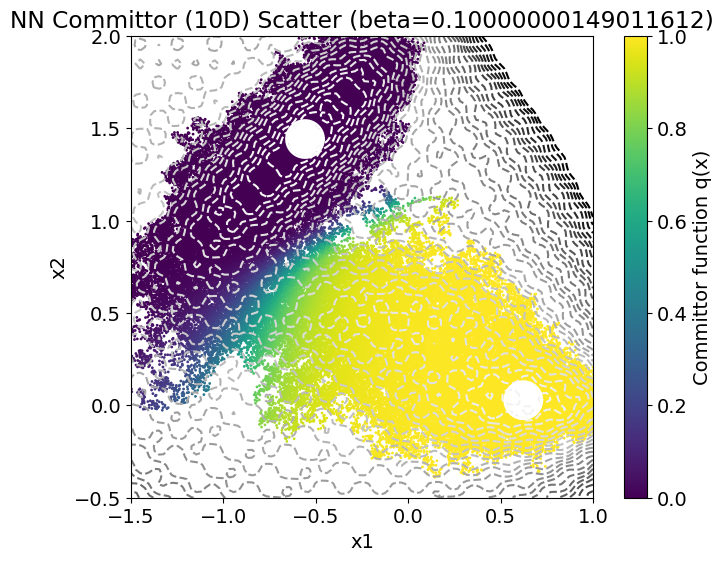

In [5]:
# ==============================================================================
# STEP 5: VISUALIZE THE FINAL COMMITTOR (SCATTER PLOT)
# ==============================================================================
print("\n--- Step 5: Visualizing the Final Committor (Scatter Plot) ---")

if train_data is not None:
    # --- Get Committor Values at Training Points ---
    print("Evaluating committor at training points...")
    # Ensure train_data is the correct tensor (output of Step 3)
    # Detach from graph for evaluation
    q_at_training_pts = qmodel(train_data.requires_grad_(False), a, b, ra, rb, ea, eb, fac).detach().numpy()
    
    # --- Prepare for Plotting ---
    # 2D potential for contours
    nx, ny = (100, 100)
    nxy = nx * ny
    x1_plot = np.linspace(xmin, xmax, nx)
    y1_plot = np.linspace(ymin, ymax, ny)
    x_grid_plot, y_grid_plot = np.meshgrid(x1_plot, y1_plot)
    x_vec_plot = np.reshape(x_grid_plot, (nxy, 1))
    y_vec_plot = np.reshape(y_grid_plot, (nxy, 1))
    xy_plot_2d = np.concatenate((x_vec_plot, y_vec_plot), axis=1)
    v_plot = Vpot_numpy_2D_rugged(xy_plot_2d)
    v_grid_plot = np.reshape(v_plot, (nx, ny))

    # --- Plotting (Scatter) ---
    plt.figure(figsize=(8, 6))
    plt.rcParams.update({'font.size': 14})
    
    # Plot the potential contours in gray/white first (background)
    # Use dashed lines like the paper
    ls = plt.contour(x_grid_plot, y_grid_plot, v_grid_plot, 
                     levels=np.linspace(np.min(v_plot), 250, 30), 
                     cmap="Greys", linestyles='dashed')
    
    # Plot the training points as a scatter plot
    # Use s=1 for small points, adjust alpha for density
    scatter = plt.scatter(xy_omegaAB[:, 0], xy_omegaAB[:, 1], 
                          c=q_at_training_pts, 
                          s=1,          # Small point size
                          cmap="viridis", # Color map
                          vmin=0, vmax=1) # Ensure color bar spans 0 to 1

    plt.colorbar(scatter, label="Committor function q(x)")
    
    # Plot boundaries of A and B (optional, but helpful)
    t = np.linspace(0, 2 * np.pi, 100)
    Abdry_x = minimum_a_2d[0] + ra.numpy() * np.cos(t)
    Abdry_y = minimum_a_2d[1] + ra.numpy() * np.sin(t)
    Bbdry_x = minimum_b_2d[0] + rb.numpy() * np.cos(t)
    Bbdry_y = minimum_b_2d[1] + rb.numpy() * np.sin(t)
    
    # Make A and B boundaries solid white circles for visibility
    plt.plot(Abdry_x, Abdry_y, linewidth=2, color='white', linestyle='solid')
    plt.plot(Bbdry_x, Bbdry_y, linewidth=2, color='white', linestyle='solid') # Or black if preferred
    
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(f"NN Committor (10D) Scatter (beta={beta.item()})")
    axes = plt.gca()
    axes.set_aspect('equal')
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    
    figname = f"RuggedMueller_10D_Committor_Scatter.pdf"
    plt.savefig(figname)
    print(f"Saved scatter plot to {figname}")
    plt.show()

else:
    print("Skipping visualization because model was not trained.")

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


--- Step 1: Extracting q=0.5 Isocommittor Contour ---
Extracted 188 vertices from the q=0.5 contour.


/var/folders/93/sb3q7jsn5yj28sq4l66p3mr00000gn/T/ipykernel_64813/117350752.py:39: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for path in cs.collections[0].get_paths():


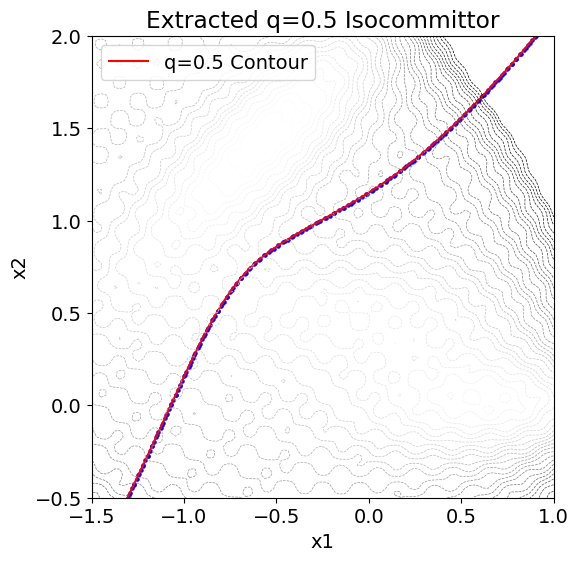


--- Step 2: Sampling Points from Contour ---
Sampling N=100 points...
Sampled 100 points.


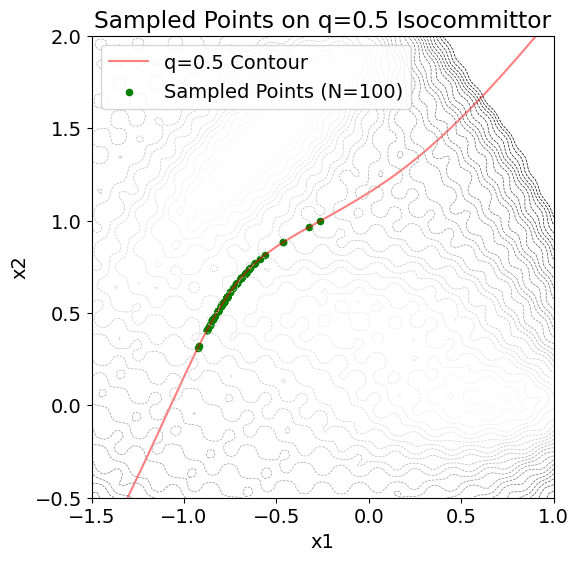


--- Step 3: Lifting Sampled Points to 10D ---
Sampling 8D coordinates from N(0, sigma_G^2 = 0.0125)
Created 100 10D starting points.

--- Step 4: Running Stochastic Trajectories (Simulations) ---
Running M=200 trajectories for each of N=100 starting points...
  Processed 10/100 starting points... (elapsed 45.4s)
  Processed 20/100 starting points... (elapsed 88.3s)
  Processed 30/100 starting points... (elapsed 133.3s)
  Processed 40/100 starting points... (elapsed 175.7s)
  Processed 50/100 starting points... (elapsed 220.6s)
  Processed 60/100 starting points... (elapsed 263.3s)
  Processed 70/100 starting points... (elapsed 306.5s)
  Processed 80/100 starting points... (elapsed 348.7s)
  Processed 90/100 starting points... (elapsed 391.9s)
Simulations finished in 436.12 seconds.

--- Step 5: Plotting Committor Probability Histogram ---


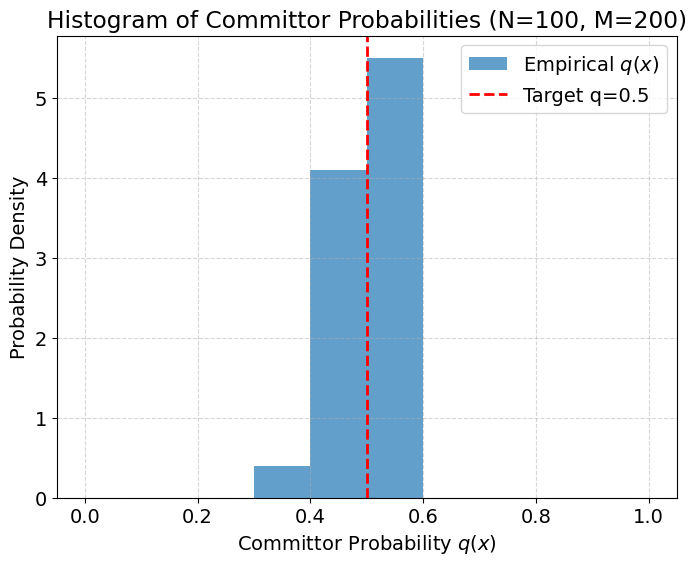

Mean empirical committor value on q=0.5 contour: 0.4974
Std deviation: 0.0499
Result: The histogram peak appears close to 0.5, suggesting the computed contour is reasonable. ✅


In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from scipy.interpolate import interp1d
import time

# Ensure qmodel is the trained 10D model from the previous steps
# Ensure Vpot_torch_2D_rugged and other parameters are defined

# ==============================================================================
# STEP 1: EXTRACT q=0.5 ISOCOMMITTOR CONTOUR
# ==============================================================================
print("--- Step 1: Extracting q=0.5 Isocommittor Contour ---")

# Evaluate the model on the 2D plot grid (same grid as visualization)
nx, ny = (100, 100) # Grid resolution
x1_plot = np.linspace(xmin, xmax, nx)
y1_plot = np.linspace(ymin, ymax, ny)
x_grid_plot, y_grid_plot = np.meshgrid(x1_plot, y1_plot)

# Pad 2D plot grid to 10D (with zeros)
xy_vec_plot = np.stack((x_grid_plot.flatten(), y_grid_plot.flatten()), axis=-1).astype(np.float32)
xy_plot_10d = np.pad(xy_vec_plot, ((0, 0), (0, 8)), 'constant')
xy_plot_torch = torch.from_numpy(xy_plot_10d)

# Get committor values on the grid
q_grid_tensor = qmodel(xy_plot_torch, a, b, ra, rb, ea, eb, fac).detach()
q_grid = np.reshape(q_grid_tensor.numpy(), (nx, ny))

# Find the contour at level 0.5
contour_level = 0.5
cs = plt.contour(x_grid_plot, y_grid_plot, q_grid, levels=[contour_level])
plt.close() # Close the dummy plot used for contour finding

# Extract vertices from the contour path(s)
# Note: There might be multiple segments, we concatenate them
contour_vertices = []
for path in cs.collections[0].get_paths():
    contour_vertices.append(path.vertices)
if not contour_vertices:
    raise ValueError("Could not find the q=0.5 contour. Check model training or contour level.")
contour_vertices = np.concatenate(contour_vertices, axis=0)

print(f"Extracted {contour_vertices.shape[0]} vertices from the q=0.5 contour.")

# Plot the contour to verify
plt.figure(figsize=(8, 6))
plt.plot(contour_vertices[:, 0], contour_vertices[:, 1], 'r-', label='q=0.5 Contour')
plt.scatter(contour_vertices[:, 0], contour_vertices[:, 1], s=5, c='blue')
# Optional: Plot potential background
v_plot = Vpot_numpy_2D_rugged(xy_vec_plot)
v_grid_plot = np.reshape(v_plot, (nx, ny))
ls_bg = plt.contour(x_grid_plot, y_grid_plot, v_grid_plot,
                 levels=np.linspace(np.min(v_plot), 250, 30),
                 cmap="Greys", linestyles='dashed', linewidths=0.5)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Extracted q=0.5 Isocommittor")
axes = plt.gca()
axes.set_aspect('equal')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.legend()
plt.show()


# ==============================================================================
# STEP 2: SAMPLE POINTS FROM CONTOUR WEIGHTED BY exp(-beta*V)
# ==============================================================================
print("\n--- Step 2: Sampling Points from Contour ---")

N = 100 # Number of points to sample (adjust N=50 if slow)
print(f"Sampling N={N} points...")

# Evaluate 2D potential at contour vertices
contour_vertices_torch = torch.from_numpy(contour_vertices).float()
V_on_contour = Vpot_torch_2D_rugged(contour_vertices_torch)

# Calculate weights (use stable version relative to minimum on contour)
V_min_contour = torch.min(V_on_contour)
weights = torch.exp(-beta * (V_on_contour - V_min_contour)).numpy()

# Normalize weights to get probabilities
probabilities = weights / np.sum(weights)

# Sample indices based on probabilities
sampled_indices = np.random.choice(len(contour_vertices), size=N, p=probabilities, replace=True)
sampled_points_2d = contour_vertices[sampled_indices]

print(f"Sampled {sampled_points_2d.shape[0]} points.")

# Plot sampled points
plt.figure(figsize=(8, 6))
plt.plot(contour_vertices[:, 0], contour_vertices[:, 1], 'r-', alpha=0.5, label='q=0.5 Contour')
plt.scatter(sampled_points_2d[:, 0], sampled_points_2d[:, 1], s=20, c='green', label=f'Sampled Points (N={N})')
ls_bg = plt.contour(x_grid_plot, y_grid_plot, v_grid_plot,
                 levels=np.linspace(np.min(v_plot), 250, 30),
                 cmap="Greys", linestyles='dashed', linewidths=0.5)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Sampled Points on q=0.5 Isocommittor")
axes = plt.gca()
axes.set_aspect('equal')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.legend()
plt.show()

# ==============================================================================
# STEP 3: LIFT SAMPLED POINTS TO 10D
# ==============================================================================
print("\n--- Step 3: Lifting Sampled Points to 10D ---")

# Calculate sigma_G for sampling 8D coordinates
sigma_quad = sigma # sigma=0.05 from parameters
beta_np = beta.numpy()
sigma_G_sq = (sigma_quad**2) / (2 * beta_np)
sigma_G = np.sqrt(sigma_G_sq)

print(f"Sampling 8D coordinates from N(0, sigma_G^2 = {sigma_G_sq:.4f})")
points_8d = np.random.normal(loc=0.0, scale=sigma_G, size=(N, 8))

# Combine to form 10D starting points
start_points_10d = np.concatenate((sampled_points_2d, points_8d), axis=1).astype(np.float32)
print(f"Created {start_points_10d.shape[0]} 10D starting points.")

# ==============================================================================
# STEP 4: RUN STOCHASTIC TRAJECTORIES (SIMULATIONS)
# ==============================================================================
print("\n--- Step 4: Running Stochastic Trajectories (Simulations) ---")

M = 200 # Number of trajectories per starting point
dt_sim = 1e-4 # Simulation time step (can be larger than metadynamics dt)
max_steps = 500000 # Max steps per trajectory to prevent infinite loops

# Define 10D potential gradient (NumPy version needed for simulation)
D_params_np = D_params_torch.numpy()
a_params_np = a_params_torch.numpy()
b_params_np = b_params_torch.numpy()
c_params_np = c_params_torch.numpy()
X_params_np = X_params_torch.numpy()
Y_params_np = Y_params_torch.numpy()
pi_np = pi.numpy()

def grad_Vpot_10D_np(x):
    """Calculates the gradient of the 10D rugged Mueller potential."""
    grad = np.zeros_like(x)
    x1, x2 = x[0], x[1]
    for D, a, b, c, X, Y in zip(D_params_np, a_params_np, b_params_np, c_params_np, X_params_np, Y_params_np):
        dx1, dx2 = x1 - X, x2 - Y
        exp_term = D * np.exp(a*dx1**2 + b*dx1*dx2 + c*dx2**2)
        grad[0] += exp_term * (2 * a * dx1 + b * dx2)
        grad[1] += exp_term * (b * dx1 + 2 * c * dx2)
    common_factor = gamma * 2 * k * pi_np
    grad[0] += common_factor * np.cos(2*k*pi_np*x1) * np.sin(2*k*pi_np*x2)
    grad[1] += common_factor * np.sin(2*k*pi_np*x1) * np.cos(2*k*pi_np*x2)
    grad[2:] = (2.0 / sigma_quad**2) * x[2:]
    return grad

# Define A and B boundaries
centerA = minimum_a_2d # [-0.558, 1.441]
centerB = minimum_b_2d # [0.623, 0.028]
radius = ra.numpy() # 0.1
radius_sq = radius**2

results = [] # Store the outcome (0 for A, 1 for B) for each trajectory
committor_probabilities = np.zeros(N)

sqrt_2_dt_beta = np.sqrt(2.0 * dt_sim / beta_np)

start_time_sim = time.time()
print(f"Running M={M} trajectories for each of N={N} starting points...")

for i in range(N):
    if i % (N // 10) == 0 and i > 0:
        elapsed = time.time() - start_time_sim
        print(f"  Processed {i}/{N} starting points... (elapsed {elapsed:.1f}s)")
        
    hits_B = 0
    start_point = start_points_10d[i]
    
    for j in range(M):
        x_current = start_point.copy()
        hit_boundary = False
        for step in range(max_steps):
            # Calculate 2D distances for boundary check
            distA_sq = np.sum((x_current[:2] - centerA)**2)
            distB_sq = np.sum((x_current[:2] - centerB)**2)
            
            # Check boundary conditions
            if distA_sq <= radius_sq:
                results.append(0) # Hit A
                hit_boundary = True
                break
            if distB_sq <= radius_sq:
                results.append(1) # Hit B
                hits_B += 1
                hit_boundary = True
                break
                
            # Euler-Maruyama step
            gradV = grad_Vpot_10D_np(x_current)
            dW = np.random.normal(0.0, 1.0, 10)
            x_current += -gradV * dt_sim + sqrt_2_dt_beta * dW
            
        if not hit_boundary:
            print(f"Warning: Trajectory {j} from point {i} exceeded max_steps without hitting A or B.")
            # Decide how to handle this - e.g., discard or assign based on nearest basin
            # For simplicity, we'll exclude it from the count for this point
            pass # Or handle differently

    # Calculate empirical committor probability for starting point i
    if M > 0: # Avoid division by zero if a point had issues
         committor_probabilities[i] = hits_B / M
    else:
         committor_probabilities[i] = np.nan # Mark as invalid

end_time_sim = time.time()
print(f"Simulations finished in {end_time_sim - start_time_sim:.2f} seconds.")

# ==============================================================================
# STEP 5: CALCULATE AND PLOT HISTOGRAM
# ==============================================================================
print("\n--- Step 5: Plotting Committor Probability Histogram ---")

plt.figure(figsize=(8, 6))
plt.hist(committor_probabilities, bins=10, range=(0, 1), density=True, alpha=0.7, label='Empirical $q(x)$')
plt.axvline(0.5, color='red', linestyle='dashed', linewidth=2, label='Target q=0.5')
plt.xlabel("Committor Probability $q(x)$")
plt.ylabel("Probability Density")
plt.title(f"Histogram of Committor Probabilities (N={N}, M={M})")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Calculate mean and std deviation
mean_q = np.nanmean(committor_probabilities)
std_q = np.nanstd(committor_probabilities)
print(f"Mean empirical committor value on q=0.5 contour: {mean_q:.4f}")
print(f"Std deviation: {std_q:.4f}")

if abs(mean_q - 0.5) < 0.1: # Check if mean is close to 0.5
    print("Result: The histogram peak appears close to 0.5, suggesting the computed contour is reasonable. ✅")
else:
    print("Result: The histogram peak is significantly different from 0.5, suggesting an issue with the computed committor. ❌")